#Fine-tuning RoBERTa for news category classification

##Import and install dependencies

The dataset can be downloaded directly from Google Cloud Storage once the GCS path is retrieved from Kaggle. It is also possible to upload it manually on Colab.

In [ ]:
#Download dataset from GCS. Path must be retrieved from Kaggle, it changes periodically
!gsutil cp "gs://kds-c40234de35222fb3227b18dbed8dc8353e8479b733fad8e0c259cc09/News_Category_Dataset_v2.json" .

Copying gs://kds-c40234de35222fb3227b18dbed8dc8353e8479b733fad8e0c259cc09/News_Category_Dataset_v2.json...
- [1 files][ 80.0 MiB/ 80.0 MiB]                                                
Operation completed over 1 objects/80.0 MiB.                                     


In [ ]:
!pip install transformers
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn


     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 57.8 MB/s 
     |████████████████████████████████| 3.3 MB 58.5 MB/s 
     |████████████████████████████████| 636 kB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


##Initialize TPU Strategy

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.59.12.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.12.250:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Batch size: 256


##Visualize and preprocess data

Let's load the data. We will combine the title and the description into a single string we will use as input for the model. 

In [ ]:
data = [json.loads(line) for line in open('./News_Category_Dataset_v2.json', 'r')] #Load data from json file
random.shuffle(data) #shuffle the data 
labels=[]
headlines=[]
texts=[]
for line in data:
    labels.append(line['category'])
    headlines.append(line['headline'])
    text=line['headline']+' '+line['short_description'] #Combine headline and description into a single text input
    texts.append(text)


Let's explore the data

In [ ]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)

Elements in dataset: 200853
41 categories found:
ARTS
ARTS & CULTURE
BLACK VOICES
BUSINESS
COLLEGE
COMEDY
CRIME
CULTURE & ARTS
DIVORCE
EDUCATION
ENTERTAINMENT
ENVIRONMENT
FIFTY
FOOD & DRINK
GOOD NEWS
GREEN
HEALTHY LIVING
HOME & LIVING
IMPACT
LATINO VOICES
MEDIA
MONEY
PARENTING
PARENTS
POLITICS
QUEER VOICES
RELIGION
SCIENCE
SPORTS
STYLE
STYLE & BEAUTY
TASTE
TECH
THE WORLDPOST
TRAVEL
WEDDINGS
WEIRD NEWS
WELLNESS
WOMEN
WORLD NEWS
WORLDPOST


Let's visualize a histogram for the categories. 

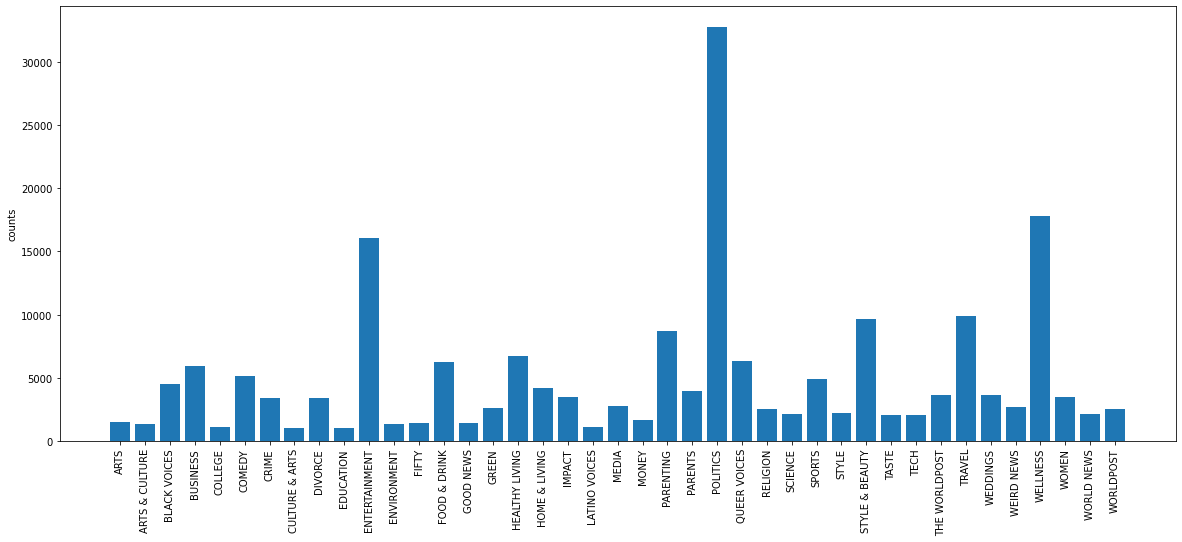

In [ ]:
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

We see that we have a lot of categories with few entries. Furthermore some categories may have a significant overlapping in meaning. Since there is a significant number of categories to predict, I will aggregate the categories that refer to related concepts. This will make them easier to be distinguished by the classifier later.

In [ ]:
def aggregate_categories(labels):
    aggregated=[]
    for line in labels:
        if line=='WORLDPOST' or line=='THE WORLDPOST':
            aggregated.append('WORLD NEWS')
        elif line=='PARENTING' or line=='PARENTS':
            aggregated.append('PARENTS & PARENTING')
        elif line=='ARTS' or line=='CULTURE & ARTS':
            aggregated.append('ARTS & CULTURE')
        elif line=='STYLE':
            aggregated.append('STYLE & BEAUTY')
        elif line=='GREEN' or line=='ENVIRONMENT':
            aggregated.append('ENVIRONMENT & GREEN')
        elif line=='HEALTHY LIVING' or line=='WELLNESS':
            aggregated.append('WELLNESS & HEALTHY LIVING')
        elif line=='COMEDY' or line=='ENTERTAINMENT':
            aggregated.append('ENTERTAINMENT & COMEDY')
        elif line=='TASTE' or line=='FOOD & DRINK':
            aggregated.append('FOOD, DRINK & TASTE')
        elif line=='COLLEGE' or line=='EDUCATION':
             aggregated.append('COLLEGE & EDUCATION')
        elif line=='SCIENCE' or line=='TECH':
             aggregated.append('SCIENCE & TECH')
        elif line=='BUSINESS' or line=='MONEY':
            aggregated.append('BUSINESS & MONEY')

        else:
            aggregated.append(line)
    return aggregated

#count number of unique categories
aggregated=aggregate_categories(labels)
categories=sorted(list(set(aggregated)))
n_categories=len(categories)
print('There are {} aggregated categories:'.format(n_categories))
for category in categories:
    print(category)


There are 28 aggregated categories:
ARTS & CULTURE
BLACK VOICES
BUSINESS & MONEY
COLLEGE & EDUCATION
CRIME
DIVORCE
ENTERTAINMENT & COMEDY
ENVIRONMENT & GREEN
FIFTY
FOOD, DRINK & TASTE
GOOD NEWS
HOME & LIVING
IMPACT
LATINO VOICES
MEDIA
PARENTS & PARENTING
POLITICS
QUEER VOICES
RELIGION
SCIENCE & TECH
SPORTS
STYLE & BEAUTY
TRAVEL
WEDDINGS
WEIRD NEWS
WELLNESS & HEALTHY LIVING
WOMEN
WORLD NEWS


Let's visualize the histogram with the aggregated categories.


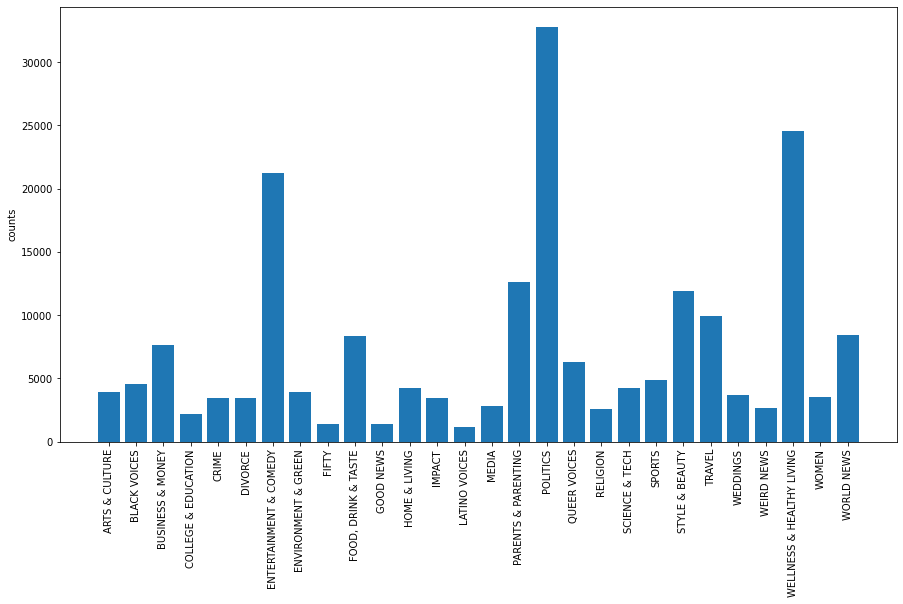

In [ ]:
fig=plt.figure(figsize=(15,8))
agg, counts = np.unique(aggregated,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,agg)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()


Let's now prepare the dataset to feed it to the model. We need to transform the category labels into indices and to tokenize the input text. The AutoTokenizer class of Huggingface allows to tokenize the dataset using the tokenizer used in the pretraining of the model. We will use the "roberta-base" model. 

In [ ]:
def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

indices=indicize_labels(aggregated) #Integer label indices
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*n_elements)
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Let's visualize how the tokenizer splits the text into (sub)words and how text gets tokenized.

In [ ]:
tokens=tokenizer(headlines[0:3], padding=True, truncation=True)['input_ids']
for i in range(3):
  print('Input:',headlines[i])
  print('Subword tokenization:',tokenizer.tokenize(headlines[i]))
  print('Indices:', tokens[i])


Input: Twitter Users Just Say No To Kellyanne Conway's Drug Abuse Cure
Subword tokenization: ['Twitter', 'ĠUsers', 'ĠJust', 'ĠSay', 'ĠNo', 'ĠTo', 'ĠKell', 'yan', 'ne', 'ĠConway', "'s", 'ĠDrug', 'ĠAbuse', 'ĠCure']
Indices: [0, 22838, 16034, 1801, 9867, 440, 598, 12702, 7010, 858, 13896, 18, 8006, 23827, 32641, 2, 1, 1, 1]
Input: Target's Wedding Dresses Are Nicer Than You Might Think (VIDEO)
Subword tokenization: ['Target', "'s", 'ĠWedding', 'ĠD', 'resses', 'ĠAre', 'ĠNic', 'er', 'ĠThan', 'ĠYou', 'ĠMight', 'ĠThink', 'Ġ(', 'VIDEO', ')']
Indices: [0, 41858, 18, 21238, 211, 13937, 3945, 13608, 254, 15446, 370, 30532, 9387, 36, 36662, 43, 2, 1, 1]
Input: Televisa Reinstates Fired Hosts, Is Investigating Sexual Harassment Claims
Subword tokenization: ['Te', 'lev', 'isa', 'ĠRe', 'inst', 'ates', 'ĠFired', 'ĠHost', 's', ',', 'ĠIs', 'ĠInvestig', 'ating', 'ĠSexual', 'ĠHar', 'assment', 'ĠClaims']
Indices: [0, 16215, 9525, 6619, 1223, 16063, 1626, 41969, 10664, 29, 6, 1534, 34850, 1295, 18600, 2482,

We see that the character 'Ġ' is used to indicate the start of a new word in the text, while the other parts of the words that get split don't contain it. For example 'reevaluate' gets split into 'Ġre' and 'evaluate'. We further notice that the tokenize uses the index 0 to indicate the beginning of the text and 2 to indicate the ending. Index 1 is reserved for padding. 

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


706/706 [==============================] - ETA: 0s - loss: 1.3817 - sparse_categorical_accuracy: 0.6499 - Sparse_Top_3_Categorical_Accuracy: 0.8207WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


706/706 [==============================] - 545s 574ms/step - loss: 1.3817 - sparse_categorical_accuracy: 0.6499 - Sparse_Top_3_Categorical_Accuracy: 0.8207 - val_loss: 0.9585 - val_sparse_categorical_accuracy: 0.7350 - val_Sparse_Top_3_Categorical_Accuracy: 0.9068
Epoch 2/6
706/706 [==============================] - 397s 562ms/step - loss: 0.8925 - sparse_categorical_accuracy: 0.7506 - Sparse_Top_3_Categorical_Accuracy: 0.9162 - val_loss: 0.8435 - val_sparse_categorical_accuracy: 0.7554 - val_Sparse_Top_3_Categorical_Accuracy: 0.9238
Epoch 3/6
706/706 [==============================] - 397s 562ms/step - loss: 0.7801 - sparse_categorical_accuracy: 0.7757 - Sparse_Top_3_Categorical_Accuracy: 0.9317 - val_loss: 0.8004 - val_sparse_categorical_accuracy: 0.7641 - val_Sparse_Top_3_Categorical_Accuracy: 0.9315
Epoch 4/6
706/706 [==============================] - 397s 562ms/step - loss: 0.7058 - sparse_categorical_accuracy: 0.7950 - Sparse_Top_3_Categorical_Accuracy: 0.9408 - val_loss: 0.7832 

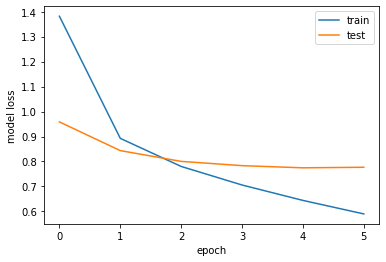

In [ ]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Sparse_Top_3_Categorical_Accuracy')],
        )
 
history=model.fit(train_ds, validation_data=val_ds, epochs=6, verbose=1)

model.save_weights('./saved_weights.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [ ]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
trained_model.load_weights('./saved_weights.h5')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels=[]
texts=[]
headlines=[]
descriptions=[]
for i in range(val_data_size):
    labels.append(data[i]['category'])
    headline=data[i]['headline']
    headlines.append(headline)
    description=data[i]['short_description']
    descriptions.append(description)
    texts.append(headline+' '+description)
labels=indicize_labels(aggregate_categories(labels))
tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
logits=model.predict(dict(tokens), verbose=1).logits
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)

628/628 [==============================] - 19s 29ms/step


Let's visualize the confusion matrix over the validation set. 

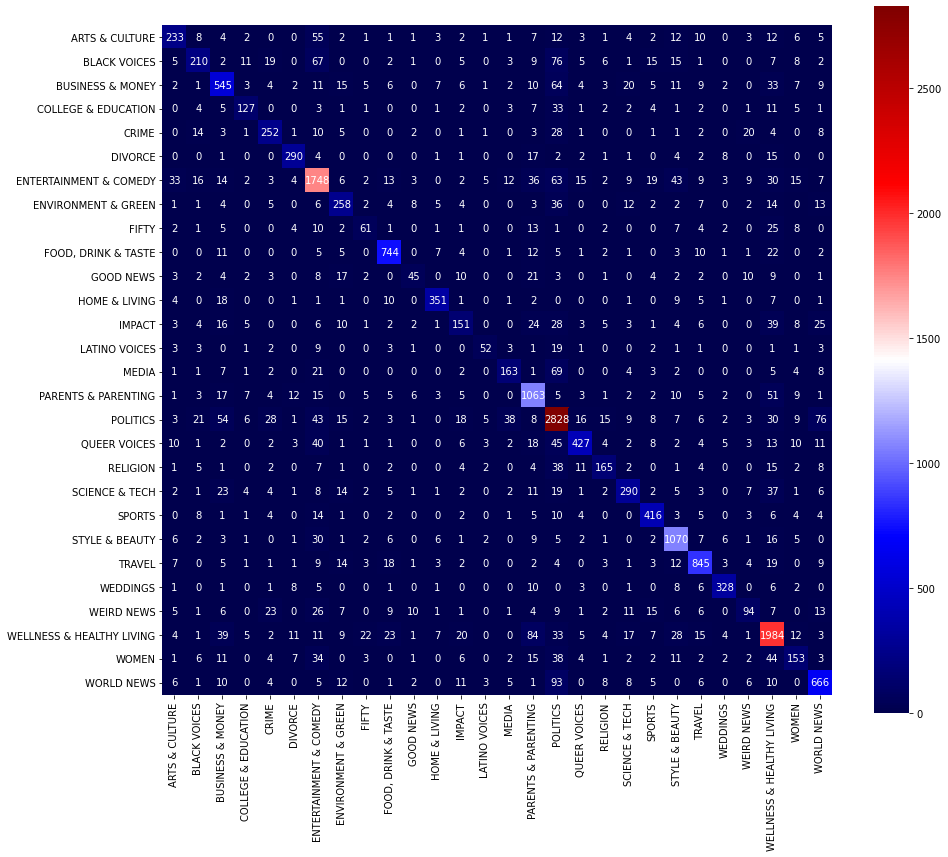

In [ ]:
import seaborn as sn
plt.figure(figsize=(15,13))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='seismic', square=True, xticklabels=categories, yticklabels=categories) 

Let's compute the (weighted) precision, recall and f1 metrics. 

In [ ]:
precision=metrics.precision_score(labels, predictions, average='weighted')
recall=metrics.recall_score(labels, predictions, average='weighted')
f1=metrics.f1_score(labels, predictions, average='weighted')
print('Precision:{}, Recall:{}, F1 score:{}.'.format(precision, recall, f1))

Precision:0.7687848713937655, Recall:0.7746577047547921, F1 score:0.7690187397056872.


Let's visualize some examples and respective top-3 predicted probabilities.

In [ ]:
def top_k_predictions(array, k): 
    top_k_indices=np.argsort(array)[-k:]
    top_k_probabilities=[]
    for i in range(k):
        top_k_probabilities.append(np.around(array[top_k_indices[i]]*100, decimals=1))
    return np.flip(top_k_indices), np.flip(top_k_probabilities)

for i in range(0, 15):
    print('HEADLINE:',headlines[i])
    print('SHORT DESCRIPTION:', descriptions[i])
    print('TRUE LABEL:', categories[labels[i]])
    top_3, top_prob=top_k_predictions(prob[i],3)
    print("Prediction 1:{} ({}%); Prediction 2:{} ({}%); Prediction 3:{} ({}%); \n".format(
          categories[top_3[0]], top_prob[0],categories[top_3[1]], top_prob[1],categories[top_3[2]], top_prob[2]) )


HEADLINE: Twitter Users Just Say No To Kellyanne Conway's Drug Abuse Cure
SHORT DESCRIPTION: Her advice: "Eat the ice cream, have the French fry, don’t buy the street drug."
TRUE LABEL: POLITICS
Prediction 1:POLITICS (31.6%); Prediction 2:WEIRD NEWS (19.7%); Prediction 3:ENTERTAINMENT & COMEDY (16.4%); 

HEADLINE: Target's Wedding Dresses Are Nicer Than You Might Think (VIDEO)
SHORT DESCRIPTION: Host Lara Spencer sat down with Brides magazine editor Lauren Ianotti to compare designer wedding gowns from the likes of
TRUE LABEL: WEDDINGS
Prediction 1:WEDDINGS (99.1%); Prediction 2:STYLE & BEAUTY (0.3%); Prediction 3:DIVORCE (0.2%); 

HEADLINE: Televisa Reinstates Fired Hosts, Is Investigating Sexual Harassment Claims
SHORT DESCRIPTION: ​Remezcla reports that Televisa has reinstated two hosts it fired earlier this week after claiming that a viral video of
TRUE LABEL: LATINO VOICES
Prediction 1:LATINO VOICES (38.3%); Prediction 2:MEDIA (32.2%); Prediction 3:WORLD NEWS (6.7%); 

HEADLINE: P

Let's compare the performance of the model when we feed only the headlines without the short description.

In [ ]:
labels=[]
texts=[]
for i in range(val_data_size):
    labels.append(data[i]['category'])
    headline=data[i]['headline']
    texts.append(headline)
labels=indicize_labels(aggregate_categories(labels))
labels=np.asarray(labels)
tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
logits=model.predict(dict(tokens), verbose=1).logits
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)
accuracy=metrics.accuracy_score(labels, predictions)
print('Accuracy on headlines only:{}'.format(accuracy))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 46) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 46) dtype=int32>]


628/628 [==============================] - 21s 26ms/step
Accuracy on headlines only:0.7048045805327359


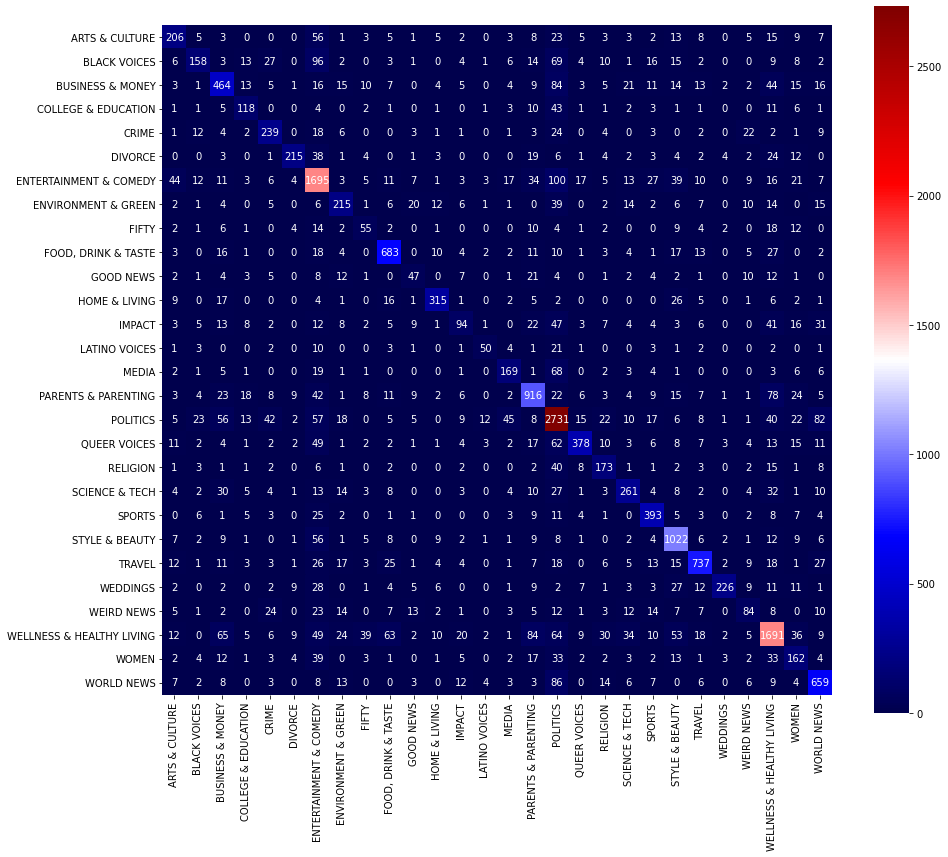

In [ ]:
plt.figure(figsize=(15,13))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='seismic', square=True, xticklabels=categories, yticklabels=categories) 

In [ ]:
precision=metrics.precision_score(labels, predictions, average='weighted')
recall=metrics.recall_score(labels, predictions, average='weighted')
f1=metrics.f1_score(labels, predictions, average='weighted')
print('Precision:{}, Recall:{}, F1 score:{}'.format(precision, recall, f1))

Precision:0.7040217496479797, Recall:0.7048045805327359, F1 score:0.6999277748192079
